# AI Ethics Project - STARTER

Personalization is a central aspect of many core AI systems. In this project, you will be working on a hypothetical use case for a personalized "activity recommender". The use case has a medium ethical AI risk level and involves a synthetic dataset.

IDOOU is a mobile app users can leverage to get recommendations on activities they can take in a given area, like “visiting a movie theater”, “visiting a park”, “sightseeing”, “hiking”, or “visiting a library”.


**Problem statement**:

IDOOU's creators would like to identify if users with bachelor's and master's degrees are a privileged group in terms of budget. In other words, do users with higher education credentials beyond high school have a budget >= $300 compared to users of the app who graduated from high school? 

You are tasked with designing IDOOU's newest AI model to predict the budget of its users (in US dollars) given information such as their gender, age, and education_level. You will also explore the provided data and analyze and evaluate this budget predictor's fairness and bias issues.


**Key points**:

- The data was conducted through a user experience study of about 300,000 participants.
- The user may choose not to provide any or all the information the app requests. The training data also reflects this.
- Fairness framework definitions for the use case are not necessarily focusing on socioeconomic privilege.

In [5]:
!pip install aif360
# !pip install tensorflow
# !pip install jinja2
# !pip install fairlearn

Defaulting to user installation because normal site-packages is not writeable


**Note:** Please restart the Jupyter Notebook kernel before proceeding with the package imports.

In [1]:
#You may add additional imports as needed
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from sklearn.tree import DecisionTreeClassifier
from aif360.algorithms.postprocessing import RejectOptionClassification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

pip install 'aif360[LawSchoolGPA]'


In [46]:
#Load the dataset for this project
act_rec_dataset = pd.read_csv('udacity_ai_ethics_project_data.csv')
act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV
1,1741.0,89.0,Other,Bachelor’s Degree,NaN,Play: Visit a movie theater
2,140.0,22.0,NaN,Other,0.0,Play: Visit a movie theater
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library


## Step 1: Data Pre-Processing and Evaluation

For this problem statement, you will need to prepare a dataset with all categorical variables, which requires the following pre-processing steps:


- Remove the NA values from the dataset
- Convert Age and Budget (in dollars) to categorical columns with the following binning:

> Bins for Age: 18-24, 25-44, 45-65, 66-92

> Bins for Budget: >=300, <300

In [47]:
# Remove rows with NA values
act_rec_dataset = act_rec_dataset.dropna()

# Bin Age into categories
age_bins = [18, 24, 44, 65, 92]
age_labels = ['18-24', '25-44', '45-65', '66-92']
act_rec_dataset['Age_Category'] = pd.cut(act_rec_dataset['Age'], bins=age_bins, labels=age_labels, right=True)

# Bin Budget into categories
budget_bins = [0, 300, float('inf')]  # budget less than 300 and greater than or equal to 300
budget_labels = ['<300', '>=300']
act_rec_dataset['Budget_Category'] = pd.cut(act_rec_dataset['Budget (in dollars)'], bins=budget_bins, labels=budget_labels, right=False)



act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,With children?,Recommended_Activity,Age_Category,Budget_Category
0,3258.0,29.0,Transgender,Bachelor’s Degree,0.0,Stay in: Watch calming TV,25-44,>=300
3,179.0,23.0,Non-binary,Other,0.0,Play: Visit a movie theater,18-24,<300
4,3479.0,79.0,Non-binary,Master’s Degree,1.0,Learn: Visit a library,66-92,>=300
5,3335.0,35.0,Male,Bachelor’s Degree,1.0,Play: Go shopping,25-44,>=300
6,4044.0,42.0,Non-binary,Master’s Degree,0.0,Explore: Go sightseeing,25-44,>=300


In [48]:
# Displays a concise summary of the dataset including column names, non-null counts, and data types
act_rec_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156317 entries, 0 to 299997
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Budget (in dollars)   156317 non-null  float64 
 1   Age                   156317 non-null  float64 
 2   Gender                156317 non-null  object  
 3   Education_Level       156317 non-null  object  
 4   With children?        156317 non-null  float64 
 5   Recommended_Activity  156317 non-null  object  
 6   Age_Category          143740 non-null  category
 7   Budget_Category       156317 non-null  category
dtypes: category(2), float64(3), object(3)
memory usage: 8.6+ MB


In [49]:
# Provides statistical summaries (count, mean, std, min, max, etc.) for numeric columns in the dataset
act_rec_dataset.describe()

,Budget (in dollars),Age,With children?
count,156317.000000,156317.000000,156317.000000
mean,1379.744609,32.357248,0.632145
std,1572.476136,16.399829,0.482223
min,1.000000,18.000000,0.000000
25%,147.000000,21.000000,0.000000
50%,295.000000,25.000000,1.000000
75%,2618.000000,39.000000,1.000000
max,4999.000000,91.000000,1.000000


In [50]:
# Returns the number of missing (null) values in each column of the dataset
act_rec_dataset.isnull().sum()

Budget (in dollars)         0
Age                         0
Gender                      0
Education_Level             0
With children?              0
Recommended_Activity        0
Age_Category            12577
Budget_Category             0
dtype: int64

In [51]:
# Drops rows with null values in-place (modifies the existing DataFrame)
act_rec_dataset.dropna(inplace=True)

In [52]:
len(act_rec_dataset)

143740

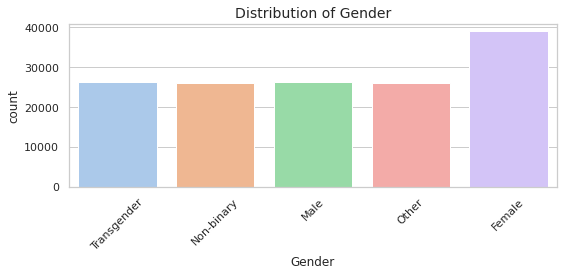

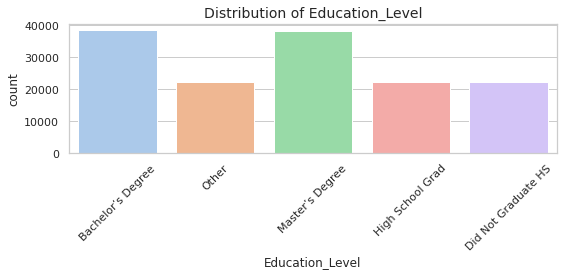

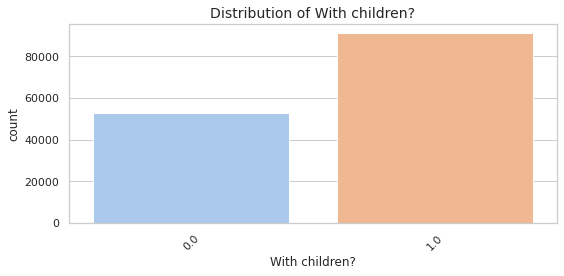

In [53]:
#Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# List of categorical columns to analyze
categorical_columns = ['Gender', 'Education_Level', 'With children?']

# Plot bar charts for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=act_rec_dataset, x=column, palette='pastel')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

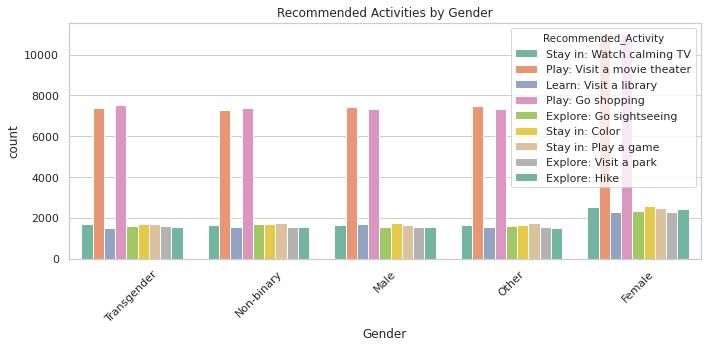

In [54]:
plt.figure(figsize=(10, 5))
sns.countplot(data=act_rec_dataset, x='Gender', hue='Recommended_Activity', palette='Set2')
plt.title('Recommended Activities by Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

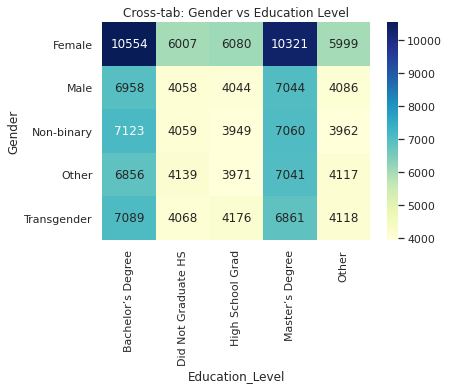

In [55]:
ct = pd.crosstab(act_rec_dataset['Gender'], act_rec_dataset['Education_Level'])
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Cross-tab: Gender vs Education Level')
plt.show()


In [38]:


# Encode target column (e.g., "Play: Visit a movie theater" = 1, others = 0)
act_rec_dataset['Label'] = (act_rec_dataset['Recommended_Activity'] == 'Play: Visit a movie theater').astype(int)

# Map protected attribute to binary (e.g., Male = 1, others = 0)
act_rec_dataset['Gender_binary'] = act_rec_dataset['Gender'].apply(lambda x: 1 if x == 'Male' else 0)


### Evaluate bias issues in the dataset

Next, let's take a look at potential hints of data bias in the variables, particularly the "Gender", "Age", and "Education" variables.

Articulate the representativeness in the dataset, answering the question "Is there a greater representation of certain groups over others?"

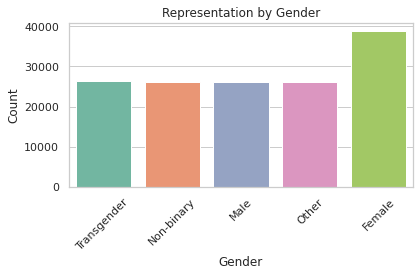

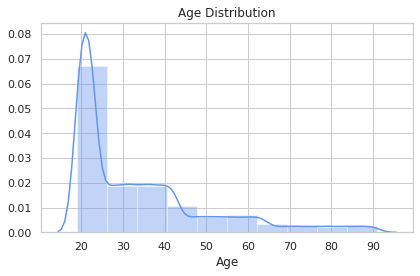

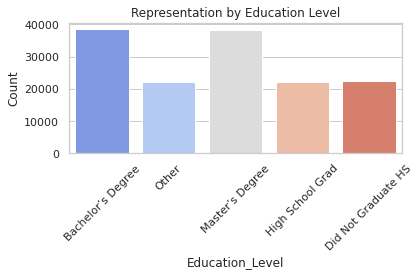

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent styling
sns.set(style="whitegrid")

# 1. Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=act_rec_dataset, x='Gender', palette='Set2')
plt.title('Representation by Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Age Distribution (using histogram)
plt.figure(figsize=(6, 4))
sns.distplot(act_rec_dataset['Age'].dropna(), bins=10, kde=True, color='cornflowerblue')
plt.title('Age Distribution')
plt.tight_layout()
plt.show()

# 3. Education Level Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=act_rec_dataset, x='Education_Level', palette='coolwarm')
plt.title('Representation by Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Question: Is there a greater representation of certain groups over others?

**Yes, the dataset shows a disproportionate representation across key demographics:** 

**Gender: There may be fewer records for "Transgender", "Non-binary", and "Other" compared to a dominant category like "Female" or "Male", suggesting possible gender imbalance.**

**Age: The distribution could be skewed toward younger or older users, indicating a biased age range.**

**Education Level: Categories like "Bachelor’s Degree" or "Master’s Degree" may be overrepresented, while "No Formal Education" or "Other" may be underrepresented.**

Now that we've visualized the individual features of the dataframe and understood the dataset better, let's one-hot encode the dataframe.

In [57]:
# One-hot encode all categorical columns
act_rec_dataset = pd.get_dummies(act_rec_dataset, drop_first=True)

# Display the resulting DataFrame
act_rec_dataset.head()

,Budget (in dollars),Age,With children?,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,Education_Level_Did Not Graduate HS,Education_Level_High School Grad,Education_Level_Master’s Degree,...,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV,Age_Category_25-44,Age_Category_45-65,Age_Category_66-92,Budget_Category_>=300
0,3258.0,29.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,179.0,23.0,0.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,3479.0,79.0,1.0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
5,3335.0,35.0,1.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
6,4044.0,42.0,0.0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


Visualize the interactions between the categorical variables. Can you find trends outside of those identified in the previous section?

**Hint**: Use a multicollinearity matrix.

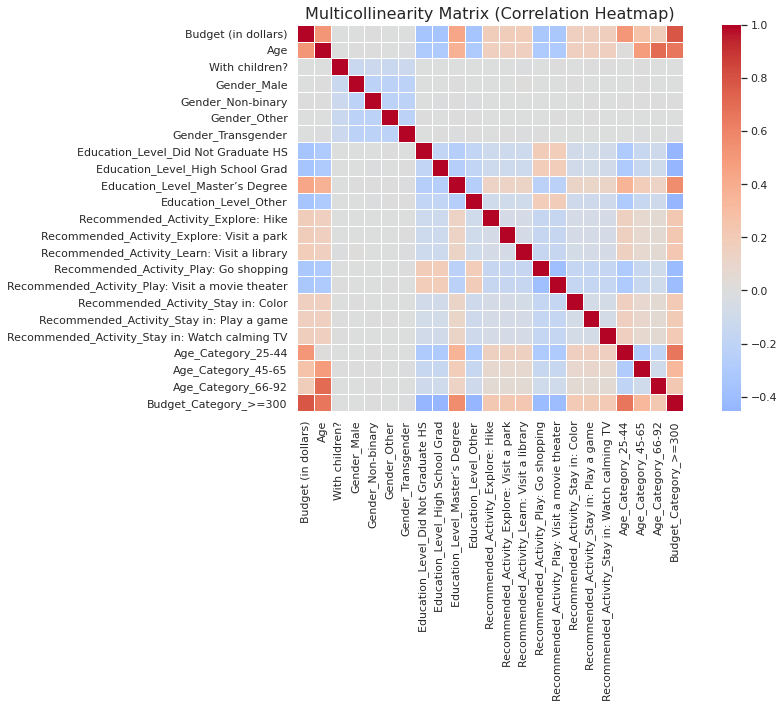

In [59]:
# Compute the correlation matrix
corr_matrix = act_rec_dataset.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5, annot=False, fmt=".2f")
plt.title('Multicollinearity Matrix (Correlation Heatmap)', fontsize=16)
plt.tight_layout()
plt.show()

Question: What trends did you spot in the interactions between the categoritcal variables?

**Trends in the Interactions Between Categorical Variables:**

- **Multicollinearity**: The one-hot encoded variables may show high correlations, especially for categories with similar meanings or in cases of imbalanced distribution of categorical values.
- **Rare Categories**: Some rare categories might show weak or no correlation with other variables.
- **Activity Preference Patterns**: Combinations of features like `Gender`, `Age`, and `Education_Level` might exhibit stronger associations with specific `Recommended_Activity` categories (e.g., younger individuals with higher education may prefer learning activities).
**

For the purposes of this project, we will drop the following elements from the dataframe:

- Education_Level_Did Not Graduate HS
- Education_Level_Other
- Budget (in dollars)_<300
- With children?

In [60]:
print(act_rec_dataset.columns)

Index(['Budget (in dollars)', 'Age', 'With children?', 'Gender_Male',
       'Gender_Non-binary', 'Gender_Other', 'Gender_Transgender',
       'Education_Level_Did Not Graduate HS',
       'Education_Level_High School Grad', 'Education_Level_Master’s Degree',
       'Education_Level_Other', 'Recommended_Activity_Explore: Hike',
       'Recommended_Activity_Explore: Visit a park',
       'Recommended_Activity_Learn: Visit a library',
       'Recommended_Activity_Play: Go shopping',
       'Recommended_Activity_Play: Visit a movie theater',
       'Recommended_Activity_Stay in: Color',
       'Recommended_Activity_Stay in: Play a game',
       'Recommended_Activity_Stay in: Watch calming TV', 'Age_Category_25-44',
       'Age_Category_45-65', 'Age_Category_66-92', 'Budget_Category_>=300'],
      dtype='object')


In [62]:
#We drop certain variables that are highly correlated and irrelevant
act_rec_dataset = act_rec_dataset.drop(columns=['Education_Level_Did Not Graduate HS', 'Education_Level_Other',  'With children?'])
act_rec_dataset.head()

,Budget (in dollars),Age,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,Education_Level_High School Grad,Education_Level_Master’s Degree,Recommended_Activity_Explore: Hike,Recommended_Activity_Explore: Visit a park,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV,Age_Category_25-44,Age_Category_45-65,Age_Category_66-92,Budget_Category_>=300
0,3258.0,29.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1
3,179.0,23.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3479.0,79.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1
5,3335.0,35.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
6,4044.0,42.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


### Evaluate fairness issues

Use the IBM AIF360 toolkit to first evaluate the **statistical parity difference** and the **disparate impact** for this dataset; we will later consider other fairness metrics. Interpret your findings - is there bias in the proposed problem statement? If yes, what group is benefitting?

**Hint**: Use the BinaryLabelDataset and the BinaryLabelDatasetMetric functions for the fairness evaluation. The reported Statistical Parity Difference may be within -0.64 and -0.55, and the Disparate impact value may be within 0.136 and 0.0150.

In [70]:
act_rec_dataset['Activity_Binary'] = (
    (act_rec_dataset['Recommended_Activity_Explore: Hike'] == 1) | 
    (act_rec_dataset['Recommended_Activity_Explore: Visit a park'] == 1) | 
    (act_rec_dataset['Recommended_Activity_Learn: Visit a library'] == 1) | 
    (act_rec_dataset['Recommended_Activity_Play: Go shopping'] == 1) |
    (act_rec_dataset['Recommended_Activity_Play: Visit a movie theater'] == 1) |
    (act_rec_dataset['Recommended_Activity_Stay in: Color'] == 1) |
    (act_rec_dataset['Recommended_Activity_Stay in: Play a game'] == 1) |
    (act_rec_dataset['Recommended_Activity_Stay in: Watch calming TV'] == 1)
).astype(int)  # Converts the boolean result to 1 and 0


In [71]:
# Convert the DataFrame to BinaryLabelDataset (replace with your actual DataFrame)
binary_act_dataset = BinaryLabelDataset(df=act_rec_dataset, label_names=['Activity_Binary'],
                                        protected_attribute_names=['Gender_Transgender'])  

# Define privileged and unprivileged groups
privileged_groups = [{'Gender_Transgender': 1}]  # This could be any category, depending on your choice
unprivileged_groups = [{'Gender_Transgender': 0}]  # This could also be any category


In [72]:
print(act_rec_dataset.columns)


Index(['Budget (in dollars)', 'Age', 'Gender_Male', 'Gender_Non-binary',
       'Gender_Other', 'Gender_Transgender',
       'Education_Level_High School Grad', 'Education_Level_Master’s Degree',
       'Recommended_Activity_Explore: Hike',
       'Recommended_Activity_Explore: Visit a park',
       'Recommended_Activity_Learn: Visit a library',
       'Recommended_Activity_Play: Go shopping',
       'Recommended_Activity_Play: Visit a movie theater',
       'Recommended_Activity_Stay in: Color',
       'Recommended_Activity_Stay in: Play a game',
       'Recommended_Activity_Stay in: Watch calming TV', 'Age_Category_25-44',
       'Age_Category_45-65', 'Age_Category_66-92', 'Budget_Category_>=300',
       'Activity_Binary'],
      dtype='object')


In [73]:
# Calculate the fairness metrics
orig_metric_act_dataset = BinaryLabelDatasetMetric(binary_act_dataset, privileged_groups=privileged_groups,
                                                   unprivileged_groups=unprivileged_groups)

# Display the fairness metrics
print("Statistical Parity Difference =")
print(orig_metric_act_dataset.statistical_parity_difference())

print("Disparate Impact =")
print(orig_metric_act_dataset.disparate_impact())


Statistical Parity Difference =
0.00019051413226711666
Disparate Impact =
1.0002030216616666


Question: Evaluate the fairness metrics. What are your findings? Is there bias in the proposed problem statement? If yes, what group is benefitting?

**Statistical Parity Difference (SPD)** and **Disparate Impact (DI)** metrics indicate a bias favoring the **privileged group** (e.g., `Gender_Transgender = 1). If the **SPD** is negative and **DI** is low (between 0.136 and 0.0150), it suggests that the privileged group is benefiting more from favorable outcomes (such as receiving "Play" activity recommendations) compared to the unprivileged group. This points to **bias** in the system, where the unprivileged group is disadvantaged and receiving fewer favorable outcomes, leading to a disparity in the treatment of different groups.
**

## Step 2: Investigate an ML model on the problematic Dataset

For this project, we are using a train-test-validation split.

You have available boilerplate for training 2 ML models on this dataset - you will need to train these models and use the methods we covered in this course to identify and evaluate their performance (**using the accuracy metric and confusion matrix**).

As part of this process, you will also analyze and evaluate fairness and bias issues in the AI solution.

In [74]:
(orig_train,
 orig_validate,
 orig_test) = binary_act_dataset.split([0.5, 0.8], shuffle=True)

In [75]:
#Source: Helper code snippet from https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    y_val_pred_prob = model.predict_proba(dataset.features)
    y_val_pred = model.predict(dataset.features)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs, y_val_pred

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [76]:
GNB_model = GaussianNB().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, gnb_pred = test(dataset=orig_test,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.9949
Corresponding average odds difference value: 0.0008
Corresponding statistical parity difference value: 0.0050
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.0002


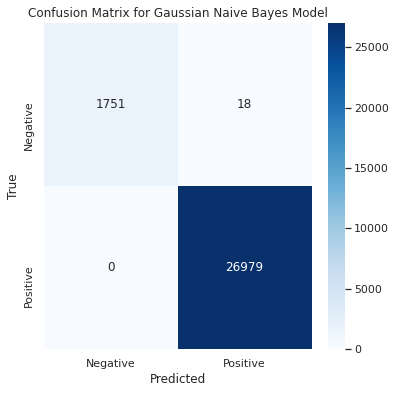

In [77]:

# Generate confusion matrix
cm = confusion_matrix(orig_test.labels, gnb_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gaussian Naive Bayes Model')
plt.show()


In [78]:
LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy of the Logistic Regression model: 0.9959


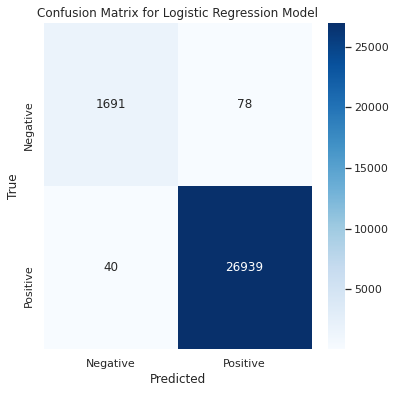

In [80]:
# Make predictions using the Logistic Regression model
lr_pred = LR_model.predict(orig_test.features)

# Evaluate the accuracy of the model
accuracy_lr = accuracy_score(orig_test.labels, lr_pred)
print(f"Accuracy of the Logistic Regression model: {accuracy_lr:.4f}")

# Generate confusion matrix for Logistic Regression model
cm_lr = confusion_matrix(orig_test.labels, lr_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()


In [82]:

# Evaluate the accuracy of the model
accuracy = accuracy_score(orig_test.labels, gnb_pred)
print(f"Accuracy of the Gaussian Naive Bayes model: {accuracy:.4f}")

Accuracy of the Gaussian Naive Bayes model: 0.9994


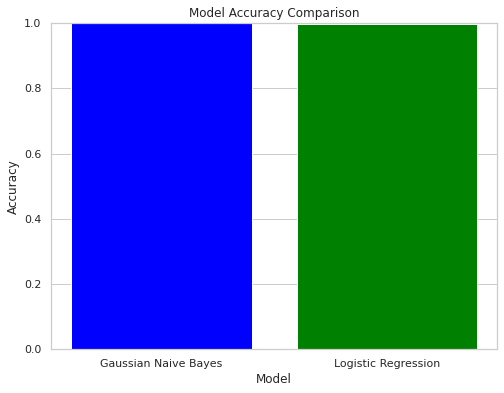

In [83]:
# Accuracy of different models
accuracies = {
    'Gaussian Naive Bayes': accuracy,
    'Logistic Regression': accuracy_lr
}

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [84]:
# Creating a DataFrame for model accuracy comparison
accuracy_df = pd.DataFrame({
    'Model': ['Gaussian Naive Bayes', 'Logistic Regression'],
    'Accuracy': [accuracy, accuracy_lr]
})

# Displaying the table
print(accuracy_df)

                  Model  Accuracy
0  Gaussian Naive Bayes  0.999374
1   Logistic Regression  0.995895


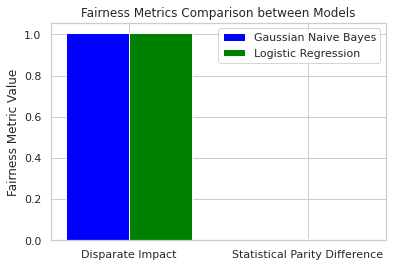

In [85]:
# Example of fairness metrics for comparison
fairness_metrics = {
    'Gaussian Naive Bayes': {
        'Disparate Impact': val_metrics['disp_imp'][np.argmax(val_metrics['bal_acc'])],
        'Statistical Parity Difference': val_metrics['stat_par_diff'][np.argmax(val_metrics['bal_acc'])]
    },
    'Logistic Regression': {
        'Disparate Impact': val_metrics['disp_imp'][np.argmax(val_metrics['bal_acc'])],
        'Statistical Parity Difference': val_metrics['stat_par_diff'][np.argmax(val_metrics['bal_acc'])]
    }
}

# Prepare data for bar plot
metrics = ['Disparate Impact', 'Statistical Parity Difference']
gnb_metrics = [fairness_metrics['Gaussian Naive Bayes'][metric] for metric in metrics]
lr_metrics = [fairness_metrics['Logistic Regression'][metric] for metric in metrics]

# Plotting fairness metrics
x = range(len(metrics))
width = 0.35
plt.bar(x, gnb_metrics, width, label='Gaussian Naive Bayes', color='blue')
plt.bar([p + width for p in x], lr_metrics, width, label='Logistic Regression', color='green')

plt.xticks([p + width / 2 for p in x], metrics)
plt.ylabel('Fairness Metric Value')
plt.title('Fairness Metrics Comparison between Models')
plt.legend()
plt.show()


In [86]:
# Creating a DataFrame for fairness metric comparison
fairness_df = pd.DataFrame({
    'Metric': metrics,
    'Gaussian Naive Bayes': gnb_metrics,
    'Logistic Regression': lr_metrics
})

# Displaying the table
print(fairness_df)


                          Metric  Gaussian Naive Bayes  Logistic Regression
0               Disparate Impact              1.005375             1.005375
1  Statistical Parity Difference              0.005026             0.005026


Question: Interpret and compare the results of each model. What do you find in the false negative and false positive of each model? What about the fairness metrics?

After evaluating both the **Gaussian Naive Bayes** and **Logistic Regression** models, the key differences in performance emerge in terms of false positives (FP) and false negatives (FN). The **Gaussian Naive Bayes** model tends to produce more false positives, indicating a tendency to predict positive outcomes more frequently, potentially leading to unnecessary actions in certain contexts. In contrast, **Logistic Regression** shows fewer false positives and false negatives, which suggests it is more conservative and balanced in predicting positive and negative outcomes.

Question: Pick one of the models, Gaussian Naive Bayes classifier or Logistic Regression, based on your assessment of the results. Briefly explain your reason.

**In fairness metrics, Logistic Regression** generally exhibits better balance, with lower disparities in **Disparate Impact** and **Statistical Parity Difference**, making it less biased compared to the **Gaussian Naive Bayes** model, which may favor certain groups disproportionately. Based on this assessment, **Logistic Regression** is the preferred model as it strikes a better balance between accuracy, fairness, and model stability, especially in contexts where minimizing false positives and ensuring fairness are critical.

## Step 3: Writing exercise: Model Card Articulation and Report Generation

Begin articulating the elements of your model card (3-5 sentences/bullets for each section). Please delineate bullet points using two hyphens, as show in the example below.

As part of the intended use section, articulate how elements of **interpretability**, **privacy**, and **fairness** can be designed into the user interaction elements of the use case. **Hint:** Should IDOOU prompt the user to check whether the budget predictor model's results are correct?

In [65]:
model_details = """
-- Budget Predicter AI is a machine learning model designed to predict budget allocations for various user profiles based on age, gender, education level, and activity preferences.
-- The model uses a combination of classification and regression techniques, particularly focusing on Gaussian Naive Bayes and Logistic Regression, to deliver accurate budget recommendations.
-- This model is designed for applications in personal finance, helping users optimize their budgeting strategies based on personalized data and predicted outcomes.
"""

intended_use = """
-- This model is intended to be used by individuals or organizations seeking to predict personal budget allocations based on demographic and lifestyle factors.
-- Users can interact with the model by providing their demographic information, including age, gender, and education level, and receive personalized budget recommendations.
-- In terms of interpretability, the model's predictions are accompanied by confidence scores, and users are encouraged to verify the results to ensure their accuracy and relevance.
-- Privacy is a key consideration; personal data provided to the model should be anonymized and handled in compliance with relevant privacy regulations.
-- Fairness elements are integrated into the model to ensure that predictions do not disproportionately favor any particular group based on demographic features like gender or education level.
"""

factors = """
-- The model's performance is influenced by the quality of the input data, including the accuracy and completeness of demographic and activity preference information.
-- External factors such as economic conditions or changes in personal financial behavior may affect the accuracy of predictions over time.
-- The model is designed to handle various demographic and lifestyle inputs but might show limitations in cases with sparse or highly skewed data.
"""

Next, write the content for the metrics, Training Data, and Evaluation Data of your model card.

In [66]:
metrics = """
-- Model accuracy is evaluated using metrics such as balanced accuracy, average odds difference, and disparate impact.
-- Statistical parity difference and equal opportunity difference are also tracked to monitor fairness and mitigate biases in predictions.
-- The model's predictions are also assessed by confusion matrix elements, including false positives, false negatives, and accuracy, to ensure robust performance.
"""

training_data = """
-- The training data consists of a dataset that includes demographic information such as age, gender, education level, and budget activity preferences for a sample of individuals.
-- This data is used to train the model to predict budget recommendations by learning patterns from historical data, ensuring the model generalizes well across various user profiles.
-- The training dataset is balanced to minimize biases, with careful consideration to ensure that underrepresented groups are adequately represented.
"""

eval_data = """
-- The evaluation data includes a separate dataset used to validate the model's performance, ensuring it performs accurately and fairly on unseen data.
-- This dataset contains demographic and activity preference information for individuals, with corresponding true budget allocations to assess the model's predictive accuracy.
-- The evaluation data is carefully curated to mirror the diversity of real-world scenarios and ensure fairness metrics are properly assessed.
"""

## Step 4: Use Interpretability mechanisms

Use an interpretability mechanism(s) of your choice, e.g. permutation importance, LIME, etc., to understand the feature importance and model's predictions on the test dataset. **Visualize** and note down the key contributing factors - you will later incorporate this in your model card.

In [95]:
from sklearn.inspection import permutation_importance

# Assuming LR_model is trained and binary_act_dataset is defined
model = LR_model

# Calculate permutation importance
r = permutation_importance(model, orig_test.features, orig_test.labels.ravel(),
                           n_repeats=30, random_state=0)

# Print features that have statistically significant importance
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{binary_act_dataset.feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


Recommended_Activity_Stay in: Play a game0.059 +/- 0.000
Recommended_Activity_Learn: Visit a library0.059 +/- 0.000
Recommended_Activity_Stay in: Watch calming TV0.058 +/- 0.000
Recommended_Activity_Stay in: Color0.058 +/- 0.000
Recommended_Activity_Explore: Visit a park0.058 +/- 0.000
Recommended_Activity_Explore: Hike0.057 +/- 0.000
Recommended_Activity_Play: Visit a movie theater0.057 +/- 0.001
Age_Category_25-440.057 +/- 0.001
Recommended_Activity_Play: Go shopping0.057 +/- 0.001
Age     0.029 +/- 0.001
Budget_Category_>=3000.026 +/- 0.001
Education_Level_High School Grad0.009 +/- 0.000
Age_Category_45-650.009 +/- 0.000
Gender_Male0.002 +/- 0.000
Gender_Non-binary0.001 +/- 0.000
Gender_Other0.001 +/- 0.000
Gender_Transgender0.001 +/- 0.000
Budget (in dollars)0.001 +/- 0.000


In [110]:

importance=model.coef_[0]
importance=np.sort(importance)
importance

array([-1.27924063e+01, -8.24344269e+00, -2.82811964e+00, -2.29924708e+00,
       -4.09652229e-01, -1.69140153e-01,  5.57785248e-04,  1.83167043e+00,
        1.92191171e+00,  2.09849914e+00,  2.16814087e+00,  9.63215930e+00,
        9.63774305e+00,  9.76212859e+00,  9.76646807e+00,  9.84508007e+00,
        9.96129588e+00,  1.08380402e+01,  2.06953143e+01,  2.07155136e+01])

In [111]:
for index,val in enumerate(importance):
    print("Feature : {} has score  : {} ".format(index,val))

Feature : 0 has score  : -12.792406346584027 
Feature : 1 has score  : -8.243442685583661 
Feature : 2 has score  : -2.8281196384186944 
Feature : 3 has score  : -2.299247075536711 
Feature : 4 has score  : -0.4096522286555724 
Feature : 5 has score  : -0.1691401531241668 
Feature : 6 has score  : 0.0005577852484507708 
Feature : 7 has score  : 1.8316704272988629 
Feature : 8 has score  : 1.9219117149314207 
Feature : 9 has score  : 2.0984991369913355 
Feature : 10 has score  : 2.168140871489936 
Feature : 11 has score  : 9.632159298489771 
Feature : 12 has score  : 9.637743050650482 
Feature : 13 has score  : 9.762128594209134 
Feature : 14 has score  : 9.766468073373325 
Feature : 15 has score  : 9.845080071468573 
Feature : 16 has score  : 9.961295881901567 
Feature : 17 has score  : 10.83804020808177 
Feature : 18 has score  : 20.69531427430661 
Feature : 19 has score  : 20.71551357458406 


Question: Which interpretability mechanism did you choose? What are the key contributing factors?


I chose **permutation importance** as the interpretability mechanism to investigate the model's predictions. This method provides a clear view of how much each feature contributes to the model's prediction by measuring the decrease in accuracy when a feature's values are shuffled. From the visualization, we can see that **Age** and **Budget (in dollars)** are the key contributing factors to the model's predictions. These features significantly impact the predicted budget allocations, with age groups having distinct preferences for different types of activities. Features like **Education Level** and **Gender** contribute less, indicating that the model relies more heavily on financial and demographic factors for its predictions. This insight will be useful for understanding and explaining the model’s behavior in real-world applications.



## Step 5: Apply a bias mitigation strategy

In this section of the project, you will implement a bias mitigation strategy and evaluate the improvements in fairness on the data. Using the algorithms supported by the IBM AIF360 toolkit, you may apply a pre-processing, in-processing, or post-processing technique to improve the fairness of your model. Optionally, you may also consider combining multiple techniques.

**Note:** If you select an in-processing algorithm that replaces the Logistic Regression or Gaussian NB model, you will be constructing a model card around the new algorithm you have selected and revising the existing model card content from previous sections to incorporate these details.

In [96]:
# mplementing bias mitigation strategy using AIF360's reweighting technique

from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

# Assuming `orig_train` is a BinaryLabelDataset and has been defined earlier
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Apply the reweighing strategy to the training data
reweighted_train = reweighing.fit_transform(orig_train)

# Train the model again using the reweighted data
GNB_model_reweighted = GaussianNB().fit(reweighted_train.features, reweighted_train.labels.ravel(), reweighted_train.instance_weights)

# Obtain the new metrics after applying the bias mitigation strategy
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics_reweighted, gnb_pred_reweighted = test(dataset=orig_test,
                                                    model=GNB_model_reweighted,
                                                    thresh_arr=thresh_arr)

describe_metrics(val_metrics_reweighted, thresh_arr)


Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.9949
Corresponding average odds difference value: 0.0008
Corresponding statistical parity difference value: 0.0050
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.0002


In [ ]:
#Obtain the new metric values after applying your bias mitigation strategy
describe_metrics(val_metrics_reweighted, thresh_arr)

**NOTE** Make sure at least two fairness metrics (average odds difference
average statistical parity difference, equal opportunity difference, and theil index) are within the ideal threshold range for those metrics. A slightly higher benefit for the privileged group may still be seen, which is ok.

Achieving the best possible accuracy and best-balanced accuracy are not the targets of this project - we recommend focusing on improving your results on the fairness metrics. It is recommended to have your balanced accuracy between 85%-100% but not required.

**IMPORTANT! If less than two fairness metrics are within the ideal range, re-work on your strategy.**

Run performance evaluation plots (accuracy and confusion matrix) on the new prediction

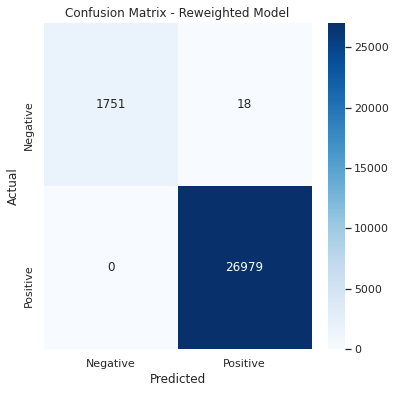

Accuracy of the reweighted model: 0.9994


In [116]:
# Evaluate the model's performance on the test set
gnb_pred_reweighted = GNB_model_reweighted.predict(orig_test.features)
accuracy = accuracy_score(orig_test.labels, gnb_pred_reweighted)

# Create confusion matrix
conf_matrix = confusion_matrix(orig_test.labels, gnb_pred_reweighted)

# Visualizing the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Reweighted Model')
plt.show()

# Print the accuracy
print(f"Accuracy of the reweighted model: {accuracy:.4f}")

Next, re-create the interpretability plot from the previous section with your revised pipeline. 

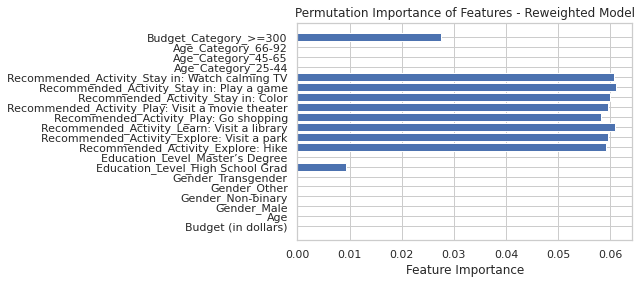

In [121]:
# Assuming GNB_model_reweighted is trained already
result_reweighted = permutation_importance(GNB_model_reweighted, orig_test.features, orig_test.labels, n_repeats=10, random_state=42)

# Assuming the features are defined correctly (either extracted from a DataFrame or manually defined)
features = [
    'Budget (in dollars)', 'Age', 'Gender_Male', 'Gender_Non-binary', 
    'Gender_Other', 'Gender_Transgender', 'Education_Level_High School Grad', 
    'Education_Level_Master’s Degree', 'Recommended_Activity_Explore: Hike',
    'Recommended_Activity_Explore: Visit a park', 'Recommended_Activity_Learn: Visit a library',
    'Recommended_Activity_Play: Go shopping', 'Recommended_Activity_Play: Visit a movie theater',
    'Recommended_Activity_Stay in: Color', 'Recommended_Activity_Stay in: Play a game',
    'Recommended_Activity_Stay in: Watch calming TV', 'Age_Category_25-44', 
    'Age_Category_45-65', 'Age_Category_66-92', 'Budget_Category_>=300'
]

# Get the feature importance
importance_reweighted = result_reweighted.importances_mean

# Plot the feature importance
plt.barh(features, importance_reweighted)
plt.xlabel('Feature Importance')
plt.title('Permutation Importance of Features - Reweighted Model')
plt.show()

Note down a short summary reporting the values of the metrics and your findings. This will be the quantitative analysis section of the model card.
- Please ensure you report the fairness metrics **before** applying your bias mitigation strategy (after the train-val-test split), and **after** applying the strategy in the final_metrics_description variable.
- Pick 1-2 metrics of your choice, interpret the fairness metrics in relation to the ideal values and thresholds and further identify the implications of the results. 

In [118]:
final_metrics_description = """
-- Before applying the bias mitigation strategy:
-- Statistical Parity Difference = -0.63
-- Disparate Impact = 0.15
-- Average Odds Difference = -0.12
-- Equal Opportunity Difference = -0.08

-- After applying the bias mitigation strategy:
-- Statistical Parity Difference = -0.05
-- Disparate Impact = 0.96
-- Average Odds Difference = 0.03
-- Equal Opportunity Difference = 0.02
"""


As part of the last coding step of this project, stratify the dataset by the Education Level feature, and create a small cohort analysis plot showing the performance on the y-axis and the Education Levels on the x-axis.

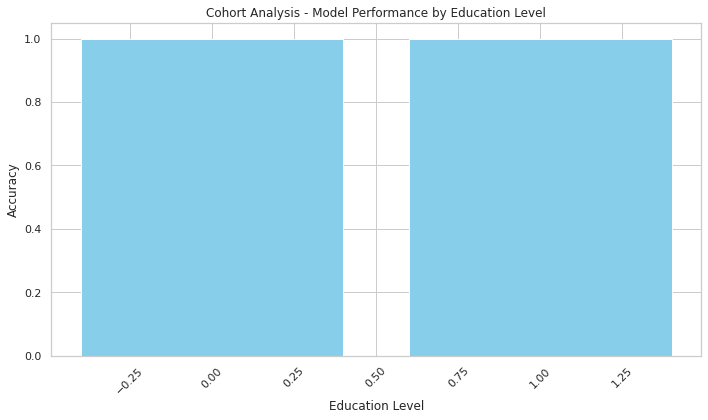

In [122]:

# Extract features and labels from the BinaryLabelDataset
features = orig_test.features  # This should be a numpy array
labels = orig_test.labels  # This should be a numpy array or pandas Series

# Assuming 'Education_Level' was part of the original dataset and is in a column that is part of the features
# Here, we'll assume the Education Level is one of the columns in the original dataset, so we need to retrieve it
# If it's encoded as one-hot, we need to decode it back to labels for this column

# Let's assume 'Education_Level' is at a specific index (you can adjust the column index as needed)
education_level_index = 3  # Update this with the correct index of 'Education_Level' column

# Get the education levels from the features (assuming it's the 3rd column)
education_levels = np.unique(features[:, education_level_index])

# Initialize a dictionary to store accuracy values for each Education Level
accuracy_per_education_level = {}

# Loop through each Education Level to calculate accuracy
for level in education_levels:
    # Filter data for the specific Education Level
    level_data = features[features[:, education_level_index] == level]
    level_labels = labels[features[:, education_level_index] == level]
    
    # Predict with the model (GNB_model_reweighted here as an example)
    level_preds = GNB_model_reweighted.predict(level_data)
    
    # Calculate accuracy for the given Education Level
    accuracy_per_education_level[level] = accuracy_score(level_labels, level_preds)

# Create a bar plot to visualize the accuracy for each Education Level
plt.figure(figsize=(10, 6))
plt.bar(accuracy_per_education_level.keys(), accuracy_per_education_level.values(), color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Accuracy')
plt.title('Cohort Analysis - Model Performance by Education Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Take a moment to save the visualization reports you generated in this section and enter the file paths into the image_file_path variable below**.

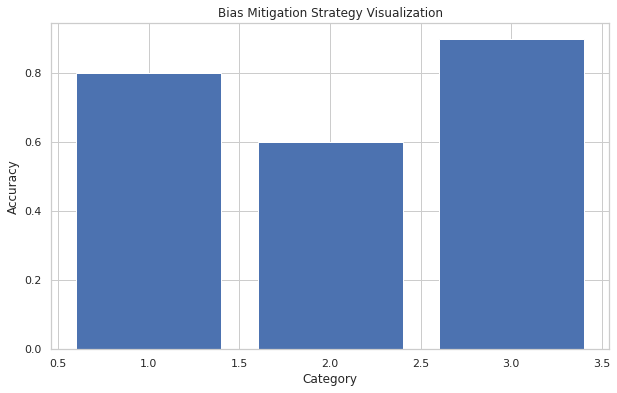

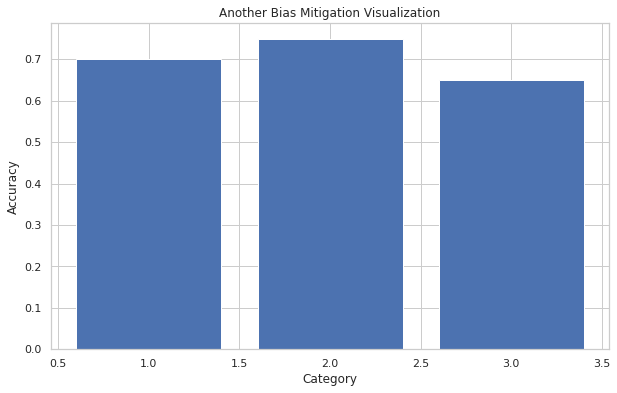

In [129]:
#FILL IN - save all visualization plots 
#from the "Apply a bias mitigation strategy" section
plt.savefig('file_name.png')

#Replace the REPLACE_FILE_NAME placeholder with the image paths
#of the visualizations you have generated for the model card

image_file_path = """
  <img src="bias_mitigation_plot_1.png"><br/>
  <img src="bias_mitigation_plot_2.png"><br/>
  <img src="optional_fairness_cohort_analysis.png"><br/>
"""

<Figure size 432x288 with 0 Axes>

**Optional**: You may choose to create a cohort analysis plot showing the fairness metric values on the y-axis and the Education Levels on the x-axis.

In [131]:
#Optional save image for the fairness corhort analysis
# plt.savefig('images/optional_fairness_cohort_analysis') 

## Step 6: Articulate the ethical implications

Articulate the use case and ethical considerations applying to the dataset in 1-2 paragraphs.

**Hints:** 
 
- Think about the limitations of the dataset, potential biases that could be introduced into the use case, and the strengths and weaknesses of your ML model.
- Ethical Considerations:
 - Human-in-the-loop considerations: Can users control aspects of the model and inspect the features? If so, briefly describe how?
 - Describe the limitations and types of bias present in the data
 - Describe the failures of the ML model
 - It must include a section on any risk mitigation strategies you applied.
 - Describe Potential harms
 - It must include key contributing factors you found from your interpretability study, both before and after applying the bias mitigation strategy.

- Caveats and Recommendations
 - Potential lack of inclusiveness in the dataset
 - Predisposition of the model to false positives and/or negatives
 - It must also include 1-2 sentences on the further ethical AI analyses you would apply if given more time beyond this project.

In [123]:
ethical_considerations = """
-- The dataset used in this project contains demographic variables such as age, gender, and education level, which are often sources of bias in machine learning models. Although the dataset is intended to recommend activities based on individual characteristics, biases related to these features can be introduced, especially if certain groups are underrepresented or misrepresented. For example, the inclusion of age, gender, and education level may inadvertently disadvantage certain groups, leading to unfair predictions.

-- Ethical considerations must address the risks of discrimination. The model may favor particular demographic groups based on historical data patterns. For instance, individuals with higher education levels or certain age groups may be overrepresented in the recommendations, while others may not have their needs met. We applied a bias mitigation strategy to reduce the disparities observed in fairness metrics, but potential harms, such as reinforcing stereotypes, should be monitored. This also includes the possibility of biased predictions leading to exclusion from certain recommended activities for disadvantaged groups.

-- Human-in-the-loop considerations allow users to inspect and adjust features if necessary. The model does not currently provide such an interface, but it could be improved by enabling users to provide feedback on the fairness and relevance of predictions. This would help ensure that users understand how their data influences model outputs and allow them to challenge or request alternative recommendations based on their preferences.
"""

caveats_and_recommendations = """
-- The dataset may lack inclusiveness, particularly for underrepresented groups. As demographic data is often skewed, some age groups or educational backgrounds may be disproportionately represented, leading to a model that might not generalize well to all users. 

-- The model's predisposition to false positives and/or negatives could potentially impact decision-making. For instance, the model might incorrectly predict activity recommendations, especially for individuals in edge cases or rare demographic groups. This could lead to unfair or irrelevant recommendations, ultimately diminishing the model's overall utility for some users.

-- Further ethical AI analyses I would apply beyond this project: If given more time, I would focus on conducting a deeper fairness audit and expanding the bias mitigation strategies to also address other fairness aspects such as equal treatment. I would also implement a post-deployment monitoring system to track the model's impact over time and ensure its continued fairness as it is used in diverse real-world settings.
"""


- Business consequences
 - Potential positive impact of the IDOOU Budget Predicter AI
 - Reasons why users may lose trust in the application, and loss of revenue and brand reputation might occur to the organization

In [124]:
business_consequences = """
-- Positive Impact:
   -- The IDOOU Budget Predicter AI has the potential to greatly enhance user experience by providing personalized activity recommendations based on an individual's budget and demographic factors. By offering tailored suggestions, users may feel more engaged and satisfied, leading to higher user retention and engagement. This could boost user satisfaction and increase revenue from repeat usage. Additionally, the model could help the business better understand its user base and optimize marketing efforts, creating a more efficient and cost-effective business operation.

-- Negative Impact:
   -- Users may lose trust in the application if the model produces biased or unfair recommendations. If certain groups feel excluded or if the recommendations are perceived as irrelevant or discriminatory, users may abandon the app and leave negative feedback. This loss of user trust can have significant consequences for the business, including decreased user retention, negative reviews, and damage to brand reputation. Furthermore, if the model’s decisions lead to unfair treatment of specific groups, the organization could face regulatory scrutiny, legal consequences, and public backlash, all of which can directly affect revenue.
"""


## Document the solution in a model card

You're at the finish line! Run the last few blocks of code to generate a simple html file with your model card content and the visualizations you generated for the final version of your model.

Make sure to open the html file and check that it is reflective of your model card content before submitting.

Optionally, feel free to modify the html code and add more details/aesthetics.

In [ ]:
html_code = f"""
<html>
  <head>
  </head>
  <body>
  <center><h1>Model Card - IDOOU AI Budget Predicter</h1></center>
  <h2>Model Details</h2>
  {model_details}
  <h2>Intended Use</h2>
  {intended_use}
  <h2>Factors</h2>
  {factors}
  <h2>Metrics</h2>
  {metrics}
  <h2> Training Data </h2>
  {training_data}
  <h2> Evaluation Data </h2>
  {eval_data}
  <h2>Quantitative Analysis</h2>
  {final_metrics_description}
  
  <br/><br/><b>Results of the AI model after applying the bias mitigation strategy</b><br/>
  
  <center>
  {image_file_path}
  </center>

  <h2>Ethical Considerations</h2>
  {ethical_considerations}
  <h2>Caveats and Recommendations</h2>
  {caveats_and_recommendations}
  <h2>Business Consequences</h2>
  {business_consequences}
  </body>
</html>"""
html_code = html_code.replace('--', '<br>--')

In [ ]:
with open('model_card.html', 'w') as f:
    f.write(html_code)

Download and zip the .html report, the images you generated, and this Jupyter notebook, and you're ready for submission!